# Predicting Objectivity of Sports Articles 

Team members:
- Anna Koval
- Dejan Dzunja
- Mohammad Ali Sadri


# Workflow
![image](./Figs/Breif_desc.png)

## 1. Problem statement

- Sports betting market is large and growing
- Bettors deal with loads of information, often misleading
- High financial risks $\rightarrow$ being well-informed is crucial

![](./Images/bet.png)

### Sports betting market

**$250 B** - estimated global market cap of international sports betting

**$39.7 B** - betting via licensed online sportsbooks

**$370 B** - expected revenue of global sports betting market by 2022

*Sources*: [Statistica](https://www.statista.com/topics/1740/sports-betting/), [Sports Betting Dime](https://www.sportsbettingdime.com/guides/finance/global-sports-betting-market/), [Technavio](https://www.technavio.com/blog/top-10-sports-betting-companies)

### Goal: Enable bettors to find objective, factual info quickly and automize process

### Solution: Predict objectivity of sports articles using ML
based on syntactic and semantic features

### Benefits of using ML solution

- No manual processing of texts $\rightarrow$ less time-consuming
- Bettors get a tool for objective assessment $\rightarrow$ less biased decisions

## 2. Loading data. Splitting into target and features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data=pd.read_excel('sport_articles_features.xlsx')
data.head()

,TextID,URL,Label,totalWordsCount,semanticobjscore,semanticsubjscore,CC,CD,DT,EX,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,Text0001,http://msn.foxsports.com/foxsoccer/mexico/stor...,objective,109,0,1,7,9,0,5,...,0,3,0,11,0,0,0,0,1,18
1,Text0002,http://msn.foxsports.com/foxsoccer/premierleag...,objective,309,21,4,1,19,1,4,...,0,10,0,13,0,14,9,1,1,14
2,Text0003,http://uk.eurosport.yahoo.com/04022011/58/fed-...,objective,149,6,1,8,14,0,5,...,0,2,0,8,0,3,2,1,1,18
3,Text0004,http://uk.eurosport.yahoo.com/07022011/58/bund...,objective,305,18,5,7,26,0,10,...,0,8,3,13,1,7,1,1,1,20
4,Text0005,http://uk.eurosport.yahoo.com/05022011/58/fed-...,objective,491,23,8,33,47,0,12,...,0,16,2,34,1,5,6,1,1,24


### Splitting data into features and target
- 61 features: syntactic and semantic characteristics of articles
- Target "Label": objective (facts) versus subjective (opinion)
- Binary classification problem

In [3]:
X = data.drop('Label', axis=1)
y = data.Label

## 3. Preprocessing data

Check for features with a single unique value

In [4]:
data.apply(axis=0, func= lambda x: len(pd.unique(x))).sort_values().head(10)

WRB             1
NNP             1
sentence1st     2
Label           2
sentencelast    2
ellipsis        2
TOs             4
WP              4
JJS             5
RBR             8
dtype: int64

Following features have only one unique value:  
- WH-adverbs (how, when, where, why)
- Singular proper nouns (Brad, Mary)  

They are not useful **$\rightarrow$ drop them**

In [5]:
X = X.drop(['WRB','NNP','TextID','URL'], axis=1)

Encode target variable

In [6]:
y = y.replace({'objective': 1, 'subjective': 0})

Replace absolute word counts by relative word counts: $count / word$

In [7]:
X.loc[:,'semanticobjscore':'present1st2nd']=X.apply(
    axis=1,
    func=lambda x: x.loc['semanticobjscore':'present1st2nd'] / x.totalWordsCount)
X= X.drop('totalWordsCount',axis=1)
X.head()

,semanticobjscore,semanticsubjscore,CC,CD,DT,EX,FW,INs,JJ,JJR,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,0.000000,0.009174,0.064220,0.082569,0.000000,0.045872,0.073394,0.055046,0.000000,0.000000,...,0.0,0.027523,0.000000,0.100917,0.000000,0.000000,0.000000,0,1,18
1,0.067961,0.012945,0.003236,0.061489,0.003236,0.012945,0.113269,0.074434,0.000000,0.000000,...,0.0,0.032362,0.000000,0.042071,0.000000,0.045307,0.029126,1,1,14
2,0.040268,0.006711,0.053691,0.093960,0.000000,0.033557,0.100671,0.073826,0.000000,0.000000,...,0.0,0.013423,0.000000,0.053691,0.000000,0.020134,0.013423,1,1,18
3,0.059016,0.016393,0.022951,0.085246,0.000000,0.032787,0.121311,0.068852,0.003279,0.003279,...,0.0,0.026230,0.009836,0.042623,0.003279,0.022951,0.003279,1,1,20
4,0.046843,0.016293,0.067210,0.095723,0.000000,0.024440,0.124236,0.073320,0.000000,0.002037,...,0.0,0.032587,0.004073,0.069246,0.002037,0.010183,0.012220,1,1,24


Check the ranges of feature values

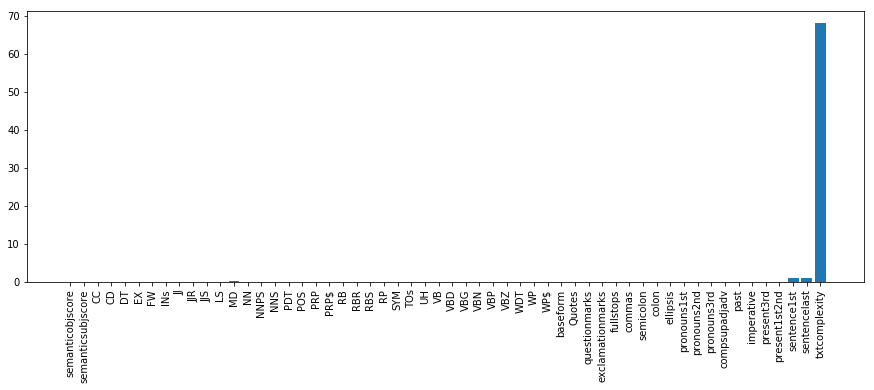

In [8]:
ranges = (X.max(0)-X.min(0))
centers = range(len(ranges))
plt.figure(figsize=(15,5))
plt.bar(centers,ranges,align='center',tick_label=X.columns);
plt.xticks(rotation=90);

Different ranges $\rightarrow$ scaling needed

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)

X_sc = pd.DataFrame(data=scaler.transform(X), columns=X.columns)



Pre-select features for visualization

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

column_names = list(X_sc)

selector = SelectKBest(f_classif,k=5)
selector.fit(X_sc,y)

scores = -np.log10(selector.pvalues_)

X_sc_K = pd.Series(data=scores, index=X_sc.columns)
X_sc_K = X_sc_K.sort_values(ascending=False)

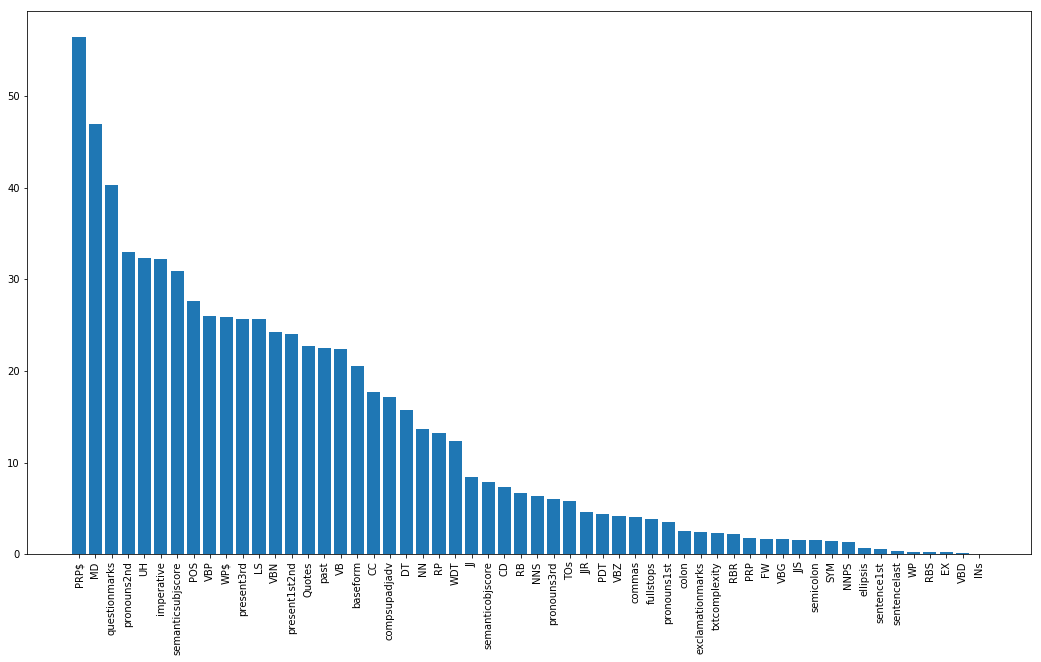

In [11]:
plt.figure(figsize=(18,10))
plt.rcParams['xtick.labelsize'] = 10
plt.bar(range(len(X_sc_K)),X_sc_K.values)
plt.xticks(range(len(X_sc_K.index)), X_sc_K.index ,rotation= 'vertical');

Top 7 features by SelectKBest:
- Possessive pronouns: *my, your, our*
- Modal auxiliaries: *should, can*
- Questions marks in the entire article
- 2nd person pronouns (personal and possessive): *you, your*
- Interjections: *uh, ouch, wow*
- Imperative verbs: *Stop! Listen!*
- Words with a subjective SENTIWORDNET score

## 4. Visual Analysis

Distribution for Target using selected features

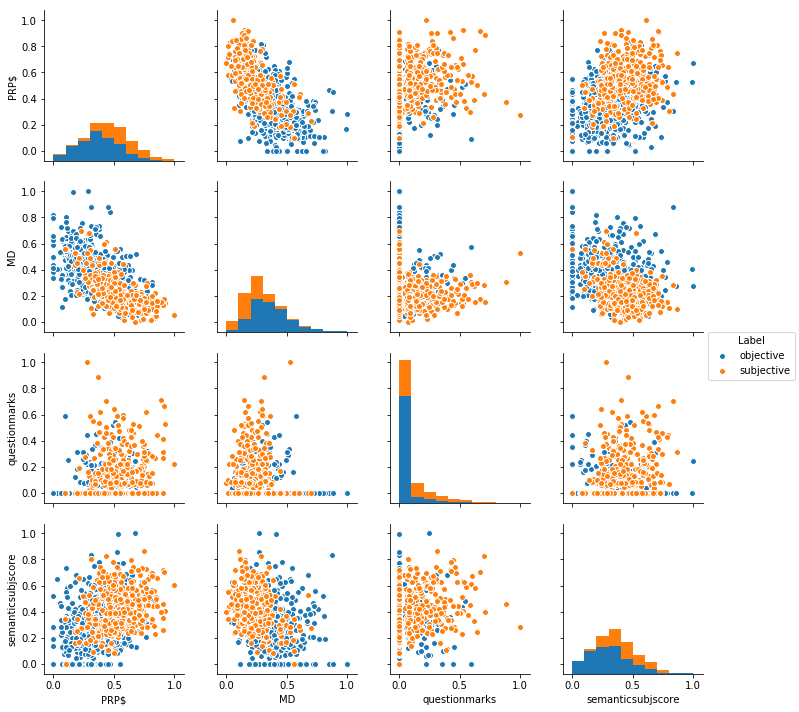

In [12]:
pairplot_1_3 = pd.concat([X_sc.loc[:,X_sc_K.index[[0,1,2,6]]], data.Label],axis=1)
sns.pairplot(pairplot_1_3 ,hue="Label",size=2.5);

- No single feature can represent the two classes well enough
- Combination of features can classify some parts of data

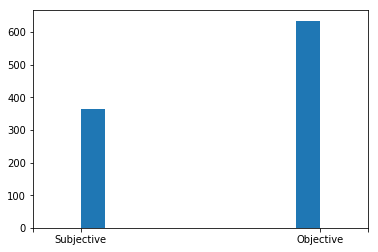

In [13]:
plt.hist(y);
plt.xticks([-.2,0,1,1.2],['','Subjective','Objective','']);

**Our dataset is unbalanced**

## 5. Implementing ML model solution

### First experiment
using SelectKBest on all features

#### Why Support Vector Machine?
- PCA attempt returned *low explained variances*  
$\rightarrow$ nonlinear problem?  
$\rightarrow$ try SVM with polynomial kernel
- High-dimensional space, many features potentially representative
- SVM successfully used in previous experiments on our data ([see paper](https://www.researchgate.net/publication/278683341_Syntactic_Genetic_Algorithm_for_a_Subjectivity_Analysis_of_Sports_Articles))

In [14]:
# Trying PCA with features selected by SelectKBest above
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_sc.loc[:,X_sc_K.index[0:7]])

print(pca.explained_variance_ratio_)

[0.50294049 0.17041655 0.12082013]


#### Setting parameters of Support Vector Classifier
- Data for classification unbalanced  
$\rightarrow$ class_weight='balanced'  
$\rightarrow$ experiment with penalty for error term *C*
- Optimize parameters for polynomial kernel: *degree* and *coef0*  
<p style="text-align:left">$(\gamma\langle x,x^\prime \rangle + r)^d$</p>
- Labels are ordered: shuffle in cross-validation
- Use scaled data

In [15]:
# Classification by SVClassifier with SelectKBest

from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif     
from sklearn.svm import SVC 

kfold = KFold(n_splits=5, shuffle=True)
cv = kfold.split(X_sc, y)
selector = SelectKBest(k=5)
clf_SVC = SVC(C=3.0, kernel='poly',
              degree=3, coef0=5, probability=True,
              class_weight='balanced', random_state=25)

clf = make_pipeline(selector, clf_SVC)
 
scores = cross_val_score(clf, X_sc, y, scoring='f1', cv=cv)
print('KFold score: {0:.4f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.8319 ± 0.023


#### Optimize parameters for the model $\rightarrow$ GridSearchCV

In [16]:
from sklearn.model_selection import GridSearchCV

## Using KFold
param_grid = {'degree': np.linspace(2,4,3),'coef0': np.linspace(3,10,8)}
grid = GridSearchCV(clf_SVC,param_grid= param_grid,verbose=1,n_jobs=-1,scoring='f1',cv=kfold)
grid.fit(X_sc,y)

print("CV F1 score: {0:.4f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))

best_coef = grid.best_params_['coef0']
best_degree = grid.best_params_['degree']

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   18.9s finished


CV F1 score: 0.8623
Best parameters: {'coef0': 5.0, 'degree': 2.0}


### Second Experiment
using set of features [chosen](https://www.researchgate.net/publication/278683341_Syntactic_Genetic_Algorithm_for_a_Subjectivity_Analysis_of_Sports_Articles) by experts

- Quotations
- Question marks
- Exclamation marks
- 1st and 2nd person pronouns: *I, you, we*
- 3rd person pronouns: *he, she, it, they*
- Past tense verbs: *did, stopped*
- Imperative tense verbs: *Listen! Look!*
- Present tense verbs: *making, play*
- Comparative and superlative adjectives and adverbs:  
*better, best, easier, easiest*
- Words with subjective SENTIWORDNET score
- Words with objective SENTIWORDNET score
- First sentence class: objective/subjective
- Last sentence class: objective/subjective

In [17]:
X_sc_ex2=X_sc.loc[:, ["Quotes", "questionmarks", "exclamationmarks", "pronouns1st", 
                      "pronouns2nd", "pronouns3rd", "VBD", "imperative", 
                      "present3rd", "present1st2nd", "sentence1st", "sentencelast", 
                      "compsupadjadv", "semanticobjscore", "semanticsubjscore"]]
X_sc_ex2.head()

,Quotes,questionmarks,exclamationmarks,pronouns1st,pronouns2nd,pronouns3rd,VBD,imperative,present3rd,present1st2nd,sentence1st,sentencelast,compsupadjadv,semanticobjscore,semanticsubjscore
0,0.000000,0.0,0.0,0.00000,0.0,0.348624,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.180639
1,0.317152,0.0,0.0,0.07964,0.0,0.409924,0.417476,0.000000,0.552957,0.456311,1.0,1.0,0.000000,0.513484,0.254882
2,0.000000,0.0,0.0,0.00000,0.0,0.170022,0.247363,0.000000,0.245729,0.210291,1.0,1.0,0.000000,0.304251,0.132145
3,0.137705,0.0,0.0,0.00000,0.0,0.332240,0.725059,0.090437,0.280104,0.051366,1.0,1.0,0.258512,0.445902,0.322781
4,0.114053,0.0,0.0,0.00000,0.0,0.412763,0.187664,0.056178,0.124283,0.191446,1.0,1.0,0.107055,0.353926,0.320809


In [18]:
# Classification by SVM with features selected by experts

from sklearn.model_selection import cross_val_score, KFold 
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC 

kfold = KFold(n_splits=5, shuffle=True)
cv = kfold.split(X_sc_ex2, y)

clf = SVC(C=3.0, kernel='poly', degree=best_degree,
          coef0=best_coef, class_weight='balanced',
          random_state=25) 

scores = cross_val_score(clf, X_sc_ex2, y, scoring='f1', cv=cv)
print('KFold score: {0:.4f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

KFold score: 0.8370 ± 0.028


## 6. Analysis of results and conclusion

- ML model proposed to classify sports articles into objective and subjective
- Cross-validation with Support Vector Classifier and SelectKBest
- SVC parameters optimized using GridSearchCV
- Best achieved CV score: **0.8623** on all features   
<br>
<br>
<table style="width:50%">
  <tr>
    <th style="font-size:20px">ML Model</th>
    <th style="font-size:20px">Specification</th> 
    <th style="font-size:20px">F1 Score</th>
  </tr>
  <tr>
    <td style="font-size:20px">SVC</td>
    <td style="font-size:20px">SelectKBest on train-set</td> 
    <td style="font-size:20px">0.8319</td>
  </tr>
  <tr>
    <td style="font-size:20px">SVC</td>
    <td style="font-size:20px">Optimized parameters with GridSearchCV</td> 
    <td style="font-size:20px">0.8623</td>
  </tr>
  <tr>
    <td style="font-size:20px">SVC</td>
    <td style="font-size:20px">Manually selected features, GridSearch best params</td> 
    <td style="font-size:20px">0.8370</td>
  </tr>
</table>
 

### Ways to improve accuracy

- Include more semantic features
- Compare with other models
- Try alternative text analysis techniques

### Applicability of ML model in real life

**Advantages**
- Features can be applied to articles on other topics

**Limitations**
- Model cannot be applied to raw texts

**Possible improvements**
- Include automized text analysis into classification

# <p style='text-align:center'>THE END</p>
  
  
![](./Images/finish.png)